In [1]:
!pip install astral
!pip install skforecast==0.13.0
!pip install shap
!pip install catboost
!pip install ipython-autotime
!pip install scikit-optimize
%load_ext autotime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.8 MB/s eta 0:00:00
time: 318 µs (started: 2025-05-21 15:10:51 +00:00)


In [2]:
# Data processing
# ==============================================================================

import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset
import seaborn as sns
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
# pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
# plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
import xgboost
import lightgbm
import catboost
import sklearn
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

import skforecast
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from skforecast.model_selection import select_features
import shap
import time

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

print(f"Version skforecast: {skforecast.__version__}")
print(f"Version scikit-learn: {sklearn.__version__}")
print(f"Version lightgbm: {lightgbm.__version__}")
print(f"Version xgboost: {xgboost.__version__}")
print(f"Version catboost: {catboost.__version__}")

Version skforecast: 0.13.0
Version scikit-learn: 1.6.1
Version lightgbm: 4.5.0
Version xgboost: 2.1.4
Version catboost: 1.2.8
time: 20.6 s (started: 2025-05-21 15:10:51 +00:00)


In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error

time: 61.3 ms (started: 2025-05-21 15:12:07 +00:00)


<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



In [4]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your file in Google Drive
file_path = '/content/drive/My Drive/BLV/Forecast/PROCESSED_DATA/load_resample_hourly_after_preprocessing.csv'

# Load the data
data = pd.read_csv(file_path, sep=',')

# Display the data
print(data.head())


Mounted at /content/drive
            Time           P
0  7/1/2022 0:00  296.416667
1  7/1/2022 1:00  278.250000
2  7/1/2022 2:00  260.666667
3  7/1/2022 3:00  249.500000
4  7/1/2022 4:00  251.750000
time: 16.9 s (started: 2025-05-21 15:12:07 +00:00)


<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



In [5]:
# Specify the path to your file in Google Drive
file_path = '/content/drive/My Drive/BLV/Forecast/PROCESSED_DATA/Hourly_weather_data.csv'

# Load the data
weather_data = pd.read_csv(file_path, sep=',')

# Display the data
print(weather_data.head())

                  Time   air temp   humidity  irrad global horizontal  \
0  2022-07-01 00:00:00  29.941667  82.991667                 0.000000   
1  2022-07-01 01:00:00  29.491667  84.450000                 0.157417   
2  2022-07-01 02:00:00  29.275000  82.858333                 0.000000   
3  2022-07-01 03:00:00  29.100000  83.125000                 0.000000   
4  2022-07-01 04:00:00  29.025000  82.716667                 0.000000   

   irrad plant of array     pressure  rain fall     temp 1     temp 2  temp 3  \
0              0.000000  1000.083333        0.0  28.433333  28.283333   -40.0   
1              0.305583   999.166667        0.0  27.875000  27.900000   -40.0   
2              0.000000   999.000000        0.0  27.716667  27.508333   -40.0   
3              0.000000   999.000000        0.0  27.216667  26.925000   -40.0   
4              0.000000   999.000000        0.0  27.366667  27.116667   -40.0   

   wind direction  wind speed  
0      230.058333    0.306333  
1      144

In [7]:
# Convert 'Time' column in both DataFrames to datetime objects
data['Time'] = pd.to_datetime(data['Time'])
weather_data['Time'] = pd.to_datetime(weather_data['Time'])

# Now perform the merge
merged_df = pd.merge(data, weather_data, on='Time', how='inner')
print(merged_df)

                     Time           P   air temp   humidity  \
0     2022-07-01 00:00:00  296.416667  29.941667  82.991667   
1     2022-07-01 01:00:00  278.250000  29.491667  84.450000   
2     2022-07-01 02:00:00  260.666667  29.275000  82.858333   
3     2022-07-01 03:00:00  249.500000  29.100000  83.125000   
4     2022-07-01 04:00:00  251.750000  29.025000  82.716667   
...                   ...         ...        ...        ...   
13195 2024-01-01 19:00:00  256.583333  22.058333  89.433333   
13196 2024-01-01 20:00:00  240.333333  21.858333  90.000000   
13197 2024-01-01 21:00:00  227.083333  21.725000  90.308333   
13198 2024-01-01 22:00:00  199.916667  21.716667  91.000000   
13199 2024-01-01 23:00:00  181.750000  21.516667  91.000000   

       irrad global horizontal  irrad plant of array     pressure  rain fall  \
0                     0.000000              0.000000  1000.083333        0.0   
1                     0.157417              0.305583   999.166667        0.0   
2  

In [6]:
target = 'P'

time: 310 µs (started: 2025-05-21 15:12:30 +00:00)


In [8]:
merged_df.describe(include = 'all')

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



,Time,P,air temp,humidity,irrad global horizontal,irrad plant of array,pressure,rain fall,temp 1,temp 2,temp 3,wind direction,wind speed
count,13200,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,2023-04-01 23:30:00,241.291846,25.538119,78.721802,176.309358,160.527168,995.092361,0.000452,28.656532,28.830983,-39.436995,199.873845,1.385194
min,2022-07-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-40.000000,0.000000,0.000000
25%,2022-11-15 11:45:00,192.979167,21.991667,74.756250,0.000000,0.000000,1003.750000,0.000000,22.106250,22.033333,-40.000000,86.012500,0.687500
50%,2023-04-01 23:30:00,241.500000,26.708333,81.250000,2.800000,2.550000,1009.000000,0.000000,26.791667,26.641667,-40.000000,234.750000,1.200000
75%,2023-08-17 11:15:00,290.083333,29.558333,86.716667,272.500000,252.312500,1014.000000,0.000000,33.241667,33.435417,-40.000000,292.083333,1.900417
max,2024-01-01 23:00:00,481.000000,35.800000,94.000000,1022.500000,1010.000000,1030.000000,4.800000,62.950000,67.833333,0.000000,360.000000,6.283333
std,NaN,67.056131,5.599471,13.156001,275.588409,253.161423,118.958291,0.041803,10.482871,10.940960,4.707047,103.822242,0.996557


time: 60.2 ms (started: 2025-05-21 15:12:38 +00:00)


In [9]:
merged_df = merged_df.set_index('Time')
merged_df = merged_df.asfreq('h')
merged_df.head()

,P,air temp,humidity,irrad global horizontal,irrad plant of array,pressure,rain fall,temp 1,temp 2,temp 3,wind direction,wind speed
Time,,,,,,,,,,,,
2022-07-01 00:00:00,296.416667,29.941667,82.991667,0.000000,0.000000,1000.083333,0.0,28.433333,28.283333,-40.0,230.058333,0.306333
2022-07-01 01:00:00,278.250000,29.491667,84.450000,0.157417,0.305583,999.166667,0.0,27.875000,27.900000,-40.0,144.166667,1.809250
2022-07-01 02:00:00,260.666667,29.275000,82.858333,0.000000,0.000000,999.000000,0.0,27.716667,27.508333,-40.0,44.666667,2.600000
2022-07-01 03:00:00,249.500000,29.100000,83.125000,0.000000,0.000000,999.000000,0.0,27.216667,26.925000,-40.0,36.133333,1.447500
2022-07-01 04:00:00,251.750000,29.025000,82.716667,0.000000,0.000000,999.000000,0.0,27.366667,27.116667,-40.0,87.091667,0.568667


time: 49.7 ms (started: 2025-05-21 15:12:40 +00:00)


In [10]:

# Tạo các cột đặc tính thời gian từ cột 'Time'
merged_df['year'] = [x for x in merged_df.index.year]
merged_df['month'] = [x for x in merged_df.index.month]
merged_df = merged_df.reset_index()
merged_df['week'] = merged_df['Time'].apply(lambda x:x.week)
merged_df = merged_df.set_index('Time')
merged_df['hour'] = [x for x in merged_df.index.hour]
merged_df['weekday'] = [(x.day_of_week + 1) for x in merged_df.index]
merged_df['day'] = [x.day for x in merged_df.index]
merged_df['day_str'] = [x.strftime('%a') for x in merged_df.index]
merged_df['year_month'] = [str(x.year) + '_' + str(x.month) for x in merged_df.index]
# Kiểm tra kết quả
print(merged_df.head())

                              P   air temp   humidity  \
Time                                                    
2022-07-01 00:00:00  296.416667  29.941667  82.991667   
2022-07-01 01:00:00  278.250000  29.491667  84.450000   
2022-07-01 02:00:00  260.666667  29.275000  82.858333   
2022-07-01 03:00:00  249.500000  29.100000  83.125000   
2022-07-01 04:00:00  251.750000  29.025000  82.716667   

                     irrad global horizontal  irrad plant of array  \
Time                                                                 
2022-07-01 00:00:00                 0.000000              0.000000   
2022-07-01 01:00:00                 0.157417              0.305583   
2022-07-01 02:00:00                 0.000000              0.000000   
2022-07-01 03:00:00                 0.000000              0.000000   
2022-07-01 04:00:00                 0.000000              0.000000   

                        pressure  rain fall     temp 1     temp 2  temp 3  \
Time                            

In [11]:
merged_df.describe()

,P,air temp,humidity,irrad global horizontal,irrad plant of array,pressure,rain fall,temp 1,temp 2,temp 3,wind direction,wind speed,year,month,week,hour,weekday,day
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,241.291846,25.538119,78.721802,176.309358,160.527168,995.092361,0.000452,28.656532,28.830983,-39.436995,199.873845,1.385194,2022.667273,7.509091,30.752727,11.500000,4.005455,15.732727
std,67.056131,5.599471,13.156001,275.588409,253.161423,118.958291,0.041803,10.482871,10.940960,4.707047,103.822242,0.996557,0.475051,3.302866,14.377949,6.922449,2.003248,8.830624
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-40.000000,0.000000,0.000000,2022.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,192.979167,21.991667,74.756250,0.000000,0.000000,1003.750000,0.000000,22.106250,22.033333,-40.000000,86.012500,0.687500,2022.000000,5.000000,20.000000,5.750000,2.000000,8.000000
50%,241.500000,26.708333,81.250000,2.800000,2.550000,1009.000000,0.000000,26.791667,26.641667,-40.000000,234.750000,1.200000,2023.000000,8.000000,33.000000,11.500000,4.000000,16.000000
75%,290.083333,29.558333,86.716667,272.500000,252.312500,1014.000000,0.000000,33.241667,33.435417,-40.000000,292.083333,1.900417,2023.000000,10.000000,43.000000,17.250000,6.000000,23.000000
max,481.000000,35.800000,94.000000,1022.500000,1010.000000,1030.000000,4.800000,62.950000,67.833333,0.000000,360.000000,6.283333,2024.000000,12.000000,52.000000,23.000000,7.000000,31.000000


time: 87.5 ms (started: 2025-05-21 15:12:47 +00:00)


In [12]:
def cyclical_encoding(data: pd.Series, cycle_length: int) -> pd.DataFrame:
    """
    Encode a cyclical feature with two new features sine and cosine.
    The minimum value of the feature is assumed to be 0. The maximum value
    of the feature is passed as an argument.

    Parameters
    ----------
    data : pd.Series
        Series with the feature to encode.
    cycle_length : int
        The length of the cycle. For example, 12 for months, 24 for hours, etc.
        This value is used to calculate the angle of the sin and cos.

    Returns
    -------
    result : pd.DataFrame
        Dataframe with the two new features sin and cos.

    """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result

time: 620 µs (started: 2025-05-21 15:12:48 +00:00)


In [13]:
month_encoded = cyclical_encoding(merged_df['month'], cycle_length=12)
week_day_encoded = cyclical_encoding(merged_df['weekday'], cycle_length=7)
hour_day_encoded = cyclical_encoding(merged_df['hour'], cycle_length=24)
#season_encoded = cyclical_encoding(data['Season'], cycle_length=4)



cyclical_features = pd.concat([
                        #year_encoded,
                        month_encoded,
                        week_day_encoded,
                        hour_day_encoded,
                        #season_encoded
                    ], axis=1)

merged_df = pd.concat([merged_df, cyclical_features], axis=1)
merged_df

,P,air temp,humidity,irrad global horizontal,irrad plant of array,pressure,rain fall,temp 1,temp 2,temp 3,...,weekday,day,day_str,year_month,month_sin,month_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
Time,,,,,,,,,,,,,,,,,,,,,
2022-07-01 00:00:00,296.416667,29.941667,82.991667,0.000000,0.000000,1000.083333,0.0,28.433333,28.283333,-40.0,...,5,1,Fri,2022_7,-0.5,-0.866025,-0.974928,-0.222521,0.000000,1.000000
2022-07-01 01:00:00,278.250000,29.491667,84.450000,0.157417,0.305583,999.166667,0.0,27.875000,27.900000,-40.0,...,5,1,Fri,2022_7,-0.5,-0.866025,-0.974928,-0.222521,0.258819,0.965926
2022-07-01 02:00:00,260.666667,29.275000,82.858333,0.000000,0.000000,999.000000,0.0,27.716667,27.508333,-40.0,...,5,1,Fri,2022_7,-0.5,-0.866025,-0.974928,-0.222521,0.500000,0.866025
2022-07-01 03:00:00,249.500000,29.100000,83.125000,0.000000,0.000000,999.000000,0.0,27.216667,26.925000,-40.0,...,5,1,Fri,2022_7,-0.5,-0.866025,-0.974928,-0.222521,0.707107,0.707107
2022-07-01 04:00:00,251.750000,29.025000,82.716667,0.000000,0.000000,999.000000,0.0,27.366667,27.116667,-40.0,...,5,1,Fri,2022_7,-0.5,-0.866025,-0.974928,-0.222521,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01 19:00:00,256.583333,22.058333,89.433333,0.000000,0.000000,1015.750000,0.0,20.600000,20.391667,-40.0,...,1,1,Mon,2024_1,0.5,0.866025,0.781831,0.623490,-0.965926,0.258819
2024-01-01 20:00:00,240.333333,21.858333,90.000000,0.000000,0.000000,1016.000000,0.0,20.508333,20.291667,-40.0,...,1,1,Mon,2024_1,0.5,0.866025,0.781831,0.623490,-0.866025,0.500000
2024-01-01 21:00:00,227.083333,21.725000,90.308333,0.000000,0.000000,1016.000000,0.0,20.291667,20.091667,-40.0,...,1,1,Mon,2024_1,0.5,0.866025,0.781831,0.623490,-0.707107,0.707107


time: 36.7 ms (started: 2025-05-21 15:12:51 +00:00)


In [18]:
exog_features = merged_df.columns
elements_to_remove = ['P','Time','year',
 'month',
 'week',
 'hour',
 'weekday',
 'day',
 'day_str',
 'year_month',
 'Season']
exog_features = [item for item in exog_features if item not in elements_to_remove]

time: 1.75 ms (started: 2025-05-21 15:13:14 +00:00)


In [19]:
target = 'P'
exog_features

['air temp',
 'humidity',
 'irrad global horizontal',
 'irrad plant of array',
 'pressure',
 'rain fall',
 'temp 1',
 'temp 2',
 'temp 3',
 'wind direction',
 'wind speed',
 'month_sin',
 'month_cos',
 'weekday_sin',
 'weekday_cos',
 'hour_sin',
 'hour_cos']

time: 2.94 ms (started: 2025-05-21 15:13:22 +00:00)


*************************************************************************
**********************************P********************************
*************************************************************************


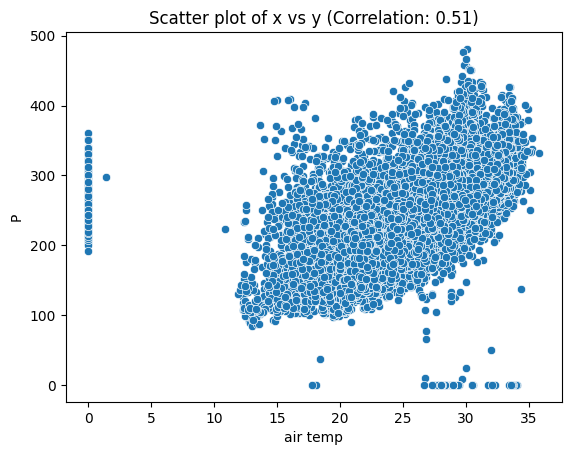

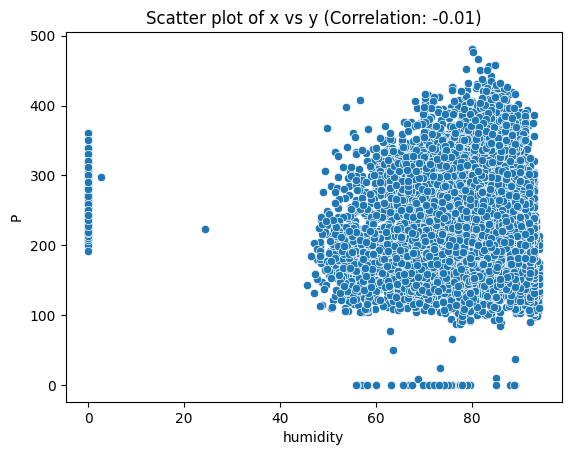

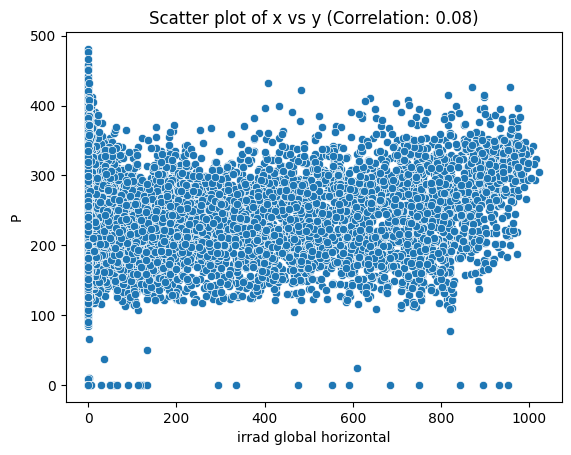

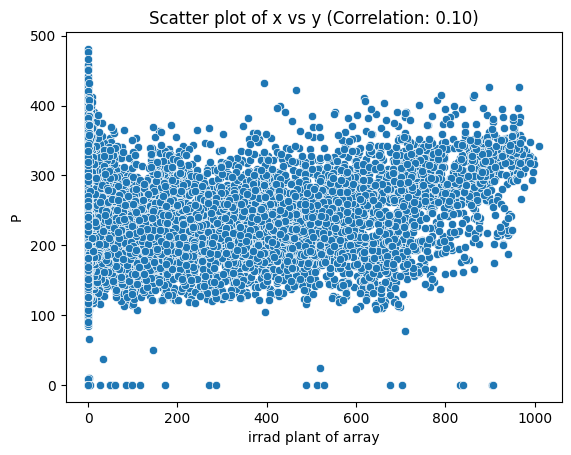

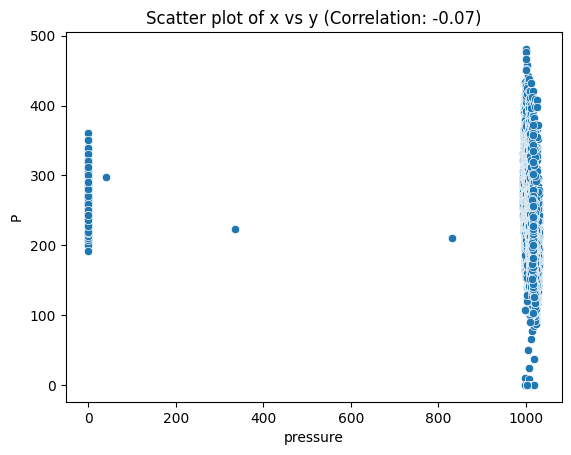

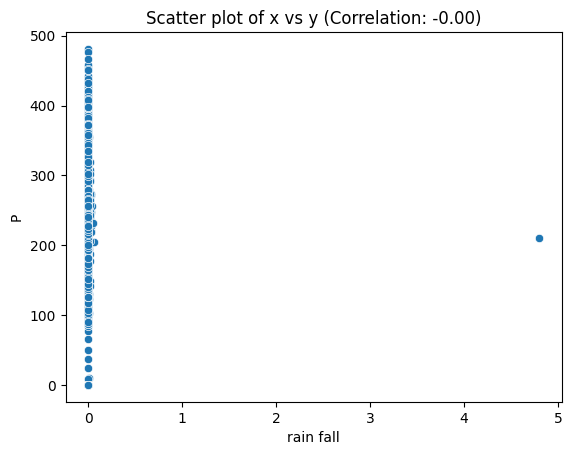

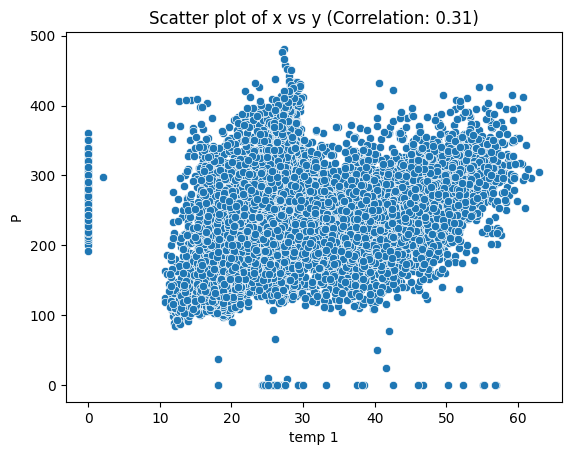

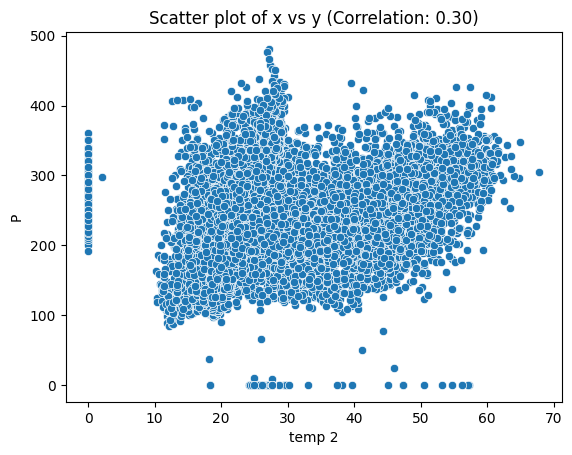

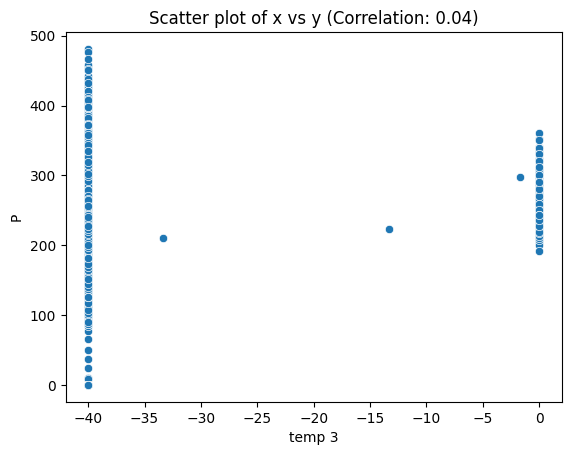

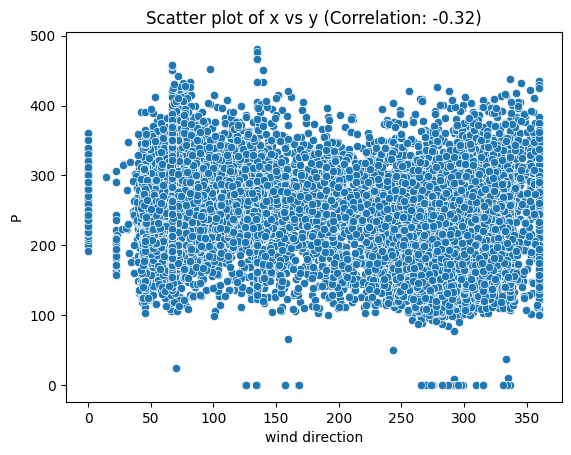

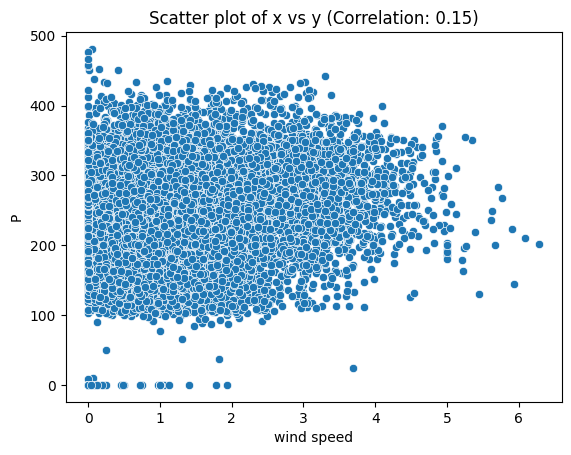

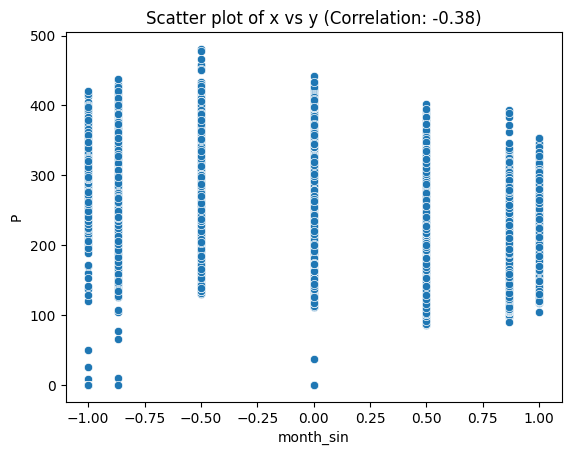

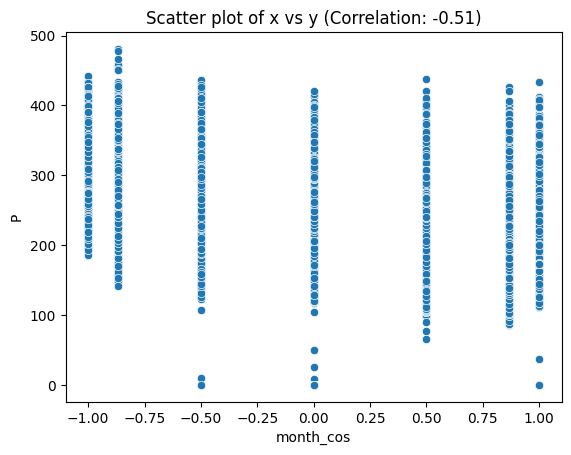

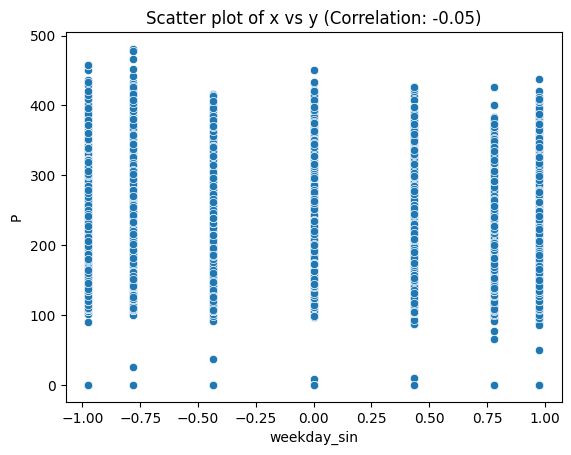

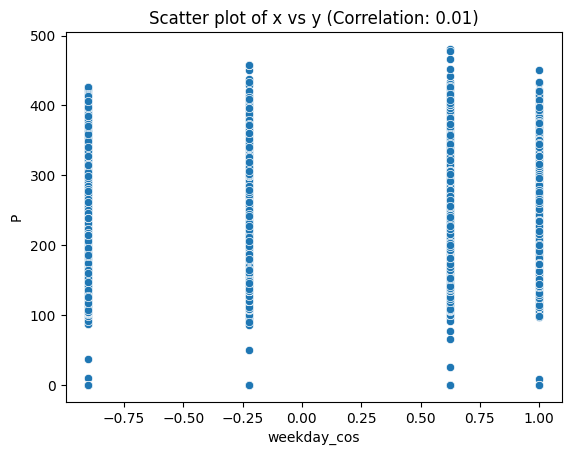

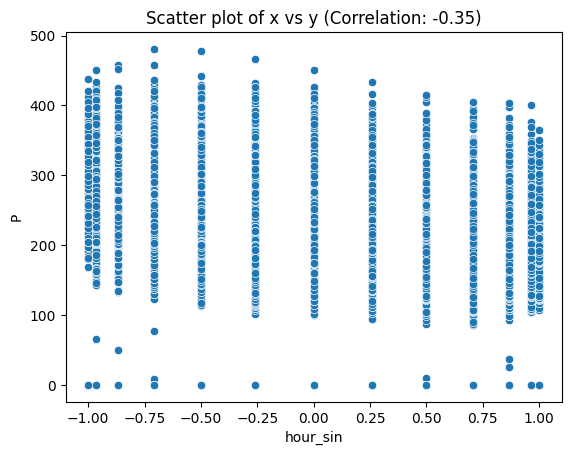

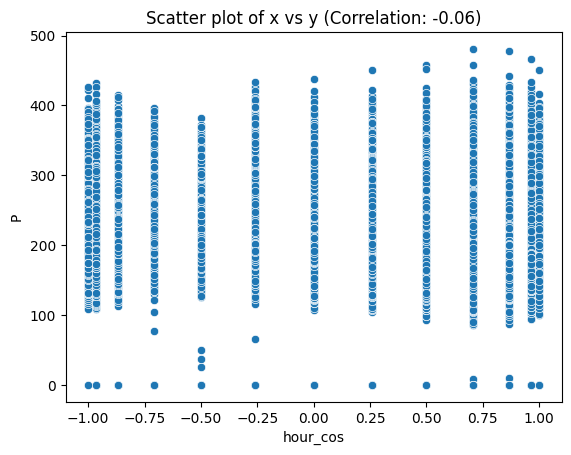

['air temp', 'temp 1', 'temp 2', 'wind direction', 'month_sin', 'month_cos', 'hour_sin']
time: 4.36 s (started: 2025-05-21 15:13:30 +00:00)


In [20]:
fe =[]
print("*************************************************************************")
print("**********************************"+target+"********************************")
print("*************************************************************************")
for i in exog_features:
    correlation = merged_df[target].corr(merged_df[i])
    # Vẽ biểu đồ
    sns.scatterplot(data=merged_df, y=target, x=i)
    # Đặt tiêu đề với hệ số tương quan
    plt.title(f'Scatter plot of x vs y (Correlation: {correlation:.2f})')
    if abs(correlation)> 0.25: fe.append(i)
    plt.show()
print(fe)

In [21]:
# Split data into train-val-test
# ==============================================================================
end_train = '2023-07-01 23:59:00'
end_validation = '2023-09-01 23:59:00'
# Infer frequency of the DateTimeIndex
data_train = merged_df.loc[: end_train, :].copy()
data_val   = merged_df.loc[end_train:end_validation, :].copy()
data_test  = merged_df.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates      : 2022-07-01 00:00:00 --- 2023-07-01 23:00:00  (n=8784)
Validation dates : 2023-07-02 00:00:00 --- 2023-09-01 23:00:00  (n=1488)
Test dates       : 2023-09-02 00:00:00 --- 2024-01-01 23:00:00  (n=2928)
time: 10.6 ms (started: 2025-05-21 15:13:37 +00:00)


In [22]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_data_splits(data_train, data_val, data_test):
    """
    Visualize train, validation, and test data splits

    Parameters:
    - data_train: Training dataset
    - data_val: Validation dataset
    - data_test: Test dataset
    """
    plt.figure(figsize=(15, 6))

    # Plot train data
    plt.plot(data_train.index, np.ones(len(data_train)),
             label='Train', color='green', marker='o', linestyle='', alpha=0.7)

    # Plot validation data
    plt.plot(data_val.index, np.ones(len(data_val)) * 1.1,
             label='Validation', color='orange', marker='o', linestyle='', alpha=0.7)

    # Plot test data
    plt.plot(data_test.index, np.ones(len(data_test)) * 1.2,
             label='Test', color='red', marker='o', linestyle='', alpha=0.7)

    plt.title('Data Split Visualization', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.yticks([1, 1.1, 1.2], ['Train', 'Validation', 'Test'])
    plt.xticks(rotation=45)

    # Adjust layout and add grid
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Add dataset size information
    plt.figtext(0.5, -0.05,
                f"Train: {len(data_train)} samples ({data_train.index.min()} - {data_train.index.max()})\n" +
                f"Validation: {len(data_val)} samples ({data_val.index.min()} - {data_val.index.max()})\n" +
                f"Test: {len(data_test)} samples ({data_test.index.min()} - {data_test.index.max()})",
                ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.show()

# Note: Replace these with your actual data variables
# visualize_data_splits(data_train, data_val, data_test)

print("Data split visualization function is ready. Call visualize_data_splits() with your datasets.")

Data split visualization function is ready. Call visualize_data_splits() with your datasets.
time: 1.56 ms (started: 2025-05-21 15:13:40 +00:00)


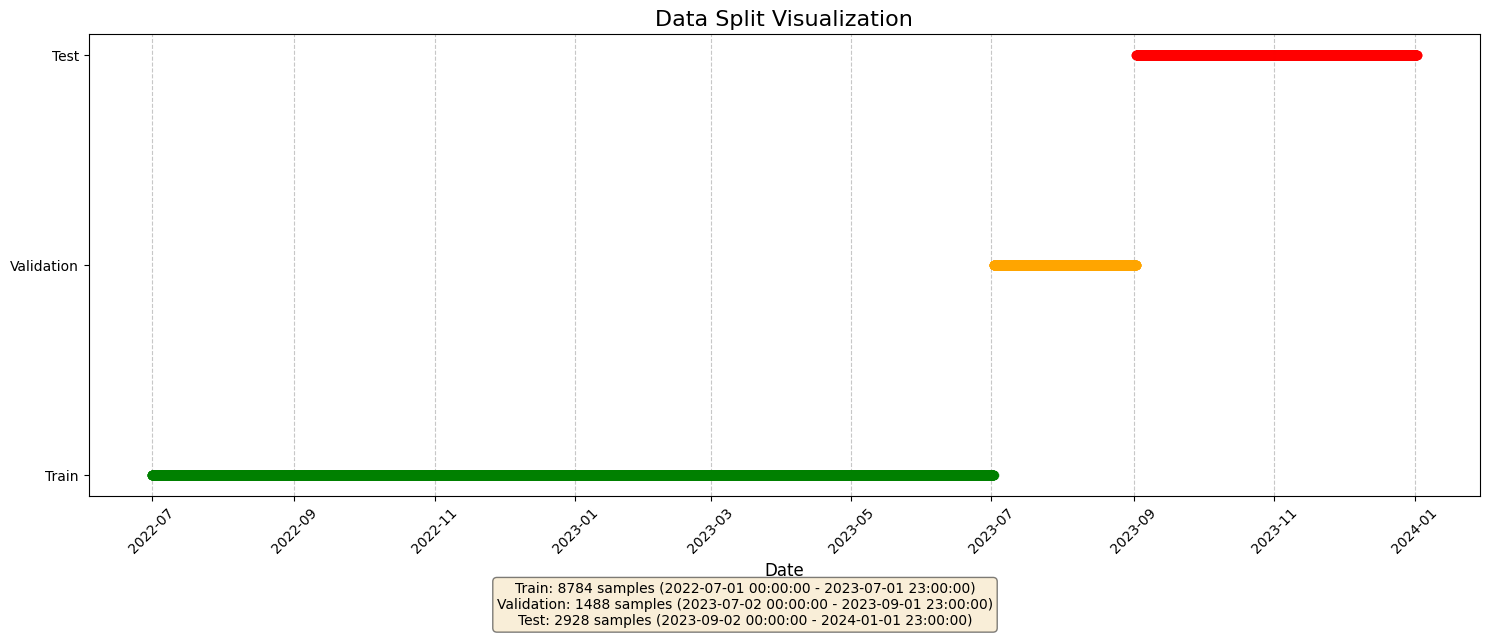

time: 273 ms (started: 2025-05-21 15:13:42 +00:00)


In [23]:
visualize_data_splits(data_train, data_val, data_test)

In [17]:
merged_df = merged_df.asfreq('h')
print(merged_df.index.freq)

<Hour>
time: 6.77 ms (started: 2025-05-21 15:13:00 +00:00)


# Autoreg_Lags_only


In [ ]:
import time
from sklearn.preprocessing import MinMaxScaler
forecaster= ForecasterAutoreg(
                    regressor = KNeighborsRegressor(),
                    lags      = 24, # This value will be replaced in the grid search
                                        #  transformer_exog = transformer_exog,

             )

# Lags used as predictors
lags_grid = [24*14,24*7]

search_spaces  = {
        'n_neighbors'          : Integer( 5, 50),
         'weights': Categorical([ 'uniform', 'distance']),
        'leaf_size'  : Integer( 30, 50),
    }

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'weights':trial.suggest_categorical('weights', ['uniform', 'distance']),
        'n_neighbors': trial.suggest_int('n_neighbors', 10, 100,step=10),
        'leaf_size': trial.suggest_int('leaf_size',30,50,step=5),
        'lags'   : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

start_time = time.time()
results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = merged_df.loc[:end_validation, target],
                                   steps              = 24,
                                   metric             = 'mean_absolute_error',
                                   search_space       = search_space,
                                   initial_train_size = len(merged_df[:end_train]),
                                   refit              = 7,
                                   n_trials           = 60, # Increase for more exhaustive search
                                   random_state       = 123,
                                   return_best        = True,
                                   verbose            = False,
                                   show_progress      = True
                               )
end_time = time.time()
turning_time = end_time - start_time
print(turning_time)

  0%|          | 0/60 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
  Parameters: {'weights': 'distance', 'n_neighbors': 30, 'leaf_size': 40}
  Backtesting metric: 25.81406440941837

477.3890709877014
time: 7min 57s (started: 2025-05-20 16:00:29 +00:00)


In [ ]:
best_params = results_search.iloc[0].params
print(best_params)

best_lags = results_search.iloc[0].lags
print(best_lags)

,lags,params,mean_absolute_error,weights,n_neighbors,leaf_size
45,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'weights': 'distance', 'n_neighbors': 30, 'le...",25.814064,distance,30,40
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'weights': 'uniform', 'n_neighbors': 30, 'lea...",25.815529,uniform,30,35
31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'weights': 'uniform', 'n_neighbors': 30, 'lea...",25.815529,uniform,30,40
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'weights': 'uniform', 'n_neighbors': 30, 'lea...",25.815529,uniform,30,35
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'weights': 'uniform', 'n_neighbors': 30, 'lea...",25.815529,uniform,30,35
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'weights': 'uniform', 'n_neighbors': 30, 'lea...",25.815529,uniform,30,30
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'weights': 'uniform', 'n_neighbors': 30, 'lea...",25.815529,uniform,30,40
28,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'weights': 'uniform', 'n_neighbors': 30, 'lea...",25.815529,uniform,30,30
51,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'weights': 'uniform', 'n_neighbors': 30, 'lea...",25.815529,uniform,30,35
52,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'weights': 'uniform', 'n_neighbors': 30, 'lea...",25.815529,uniform,30,35


time: 86 ms (started: 2025-05-20 16:19:26 +00:00)


In [ ]:
import time

# Siêu tham số tốt nhất sau quá trình tuning
# Tạo lại forecaster với các siêu tham số tốt nhất
forecaster= ForecasterAutoreg(
                    regressor = KNeighborsRegressor(**best_params),
                    lags      = best_lags, # This value will be replaced in the grid search
                                        #  transformer_exog = transformer_exog,

             )
start_time = time.time()
# Huấn luyện lại forecaster với dữ liệu huấn luyện
forecaster.fit(y=merged_df.loc[:end_validation, target])
# Backtesting model
# ==============================================================================
end_time = time.time()
train_time = end_time - start_time
print(train_time)

2.6379716396331787
time: 2.64 s (started: 2025-05-20 16:21:12 +00:00)


In [ ]:
start_time = time.time()
#
# Backtesting model
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=merged_df[target],
    steps=24,
    metric='mean_absolute_error',
    fixed_train_size   = True,
    initial_train_size=len(merged_df[:end_validation]),
    refit=7,
    n_jobs=2,
    verbose=False,
    show_progress=True
)
end_time = time.time()
# Extract the numeric value from the DataFrame
test_time = end_time - start_time
print(test_time)
# Extract the numeric value from the DataFrame
metric


/usr/local/lib/python3.11/dist-packages/skforecast/model_selection/model_selection.py:407: IgnoredArgumentWarning:

If `refit` is an integer other than 1 (intermittent refit). `n_jobs` is set to 1 to avoid unexpected results during parallelization. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)



  0%|          | 0/122 [00:00<?, ?it/s]

16.57575511932373


,mean_absolute_error
0,22.228271


time: 16.6 s (started: 2025-05-20 16:21:15 +00:00)


<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



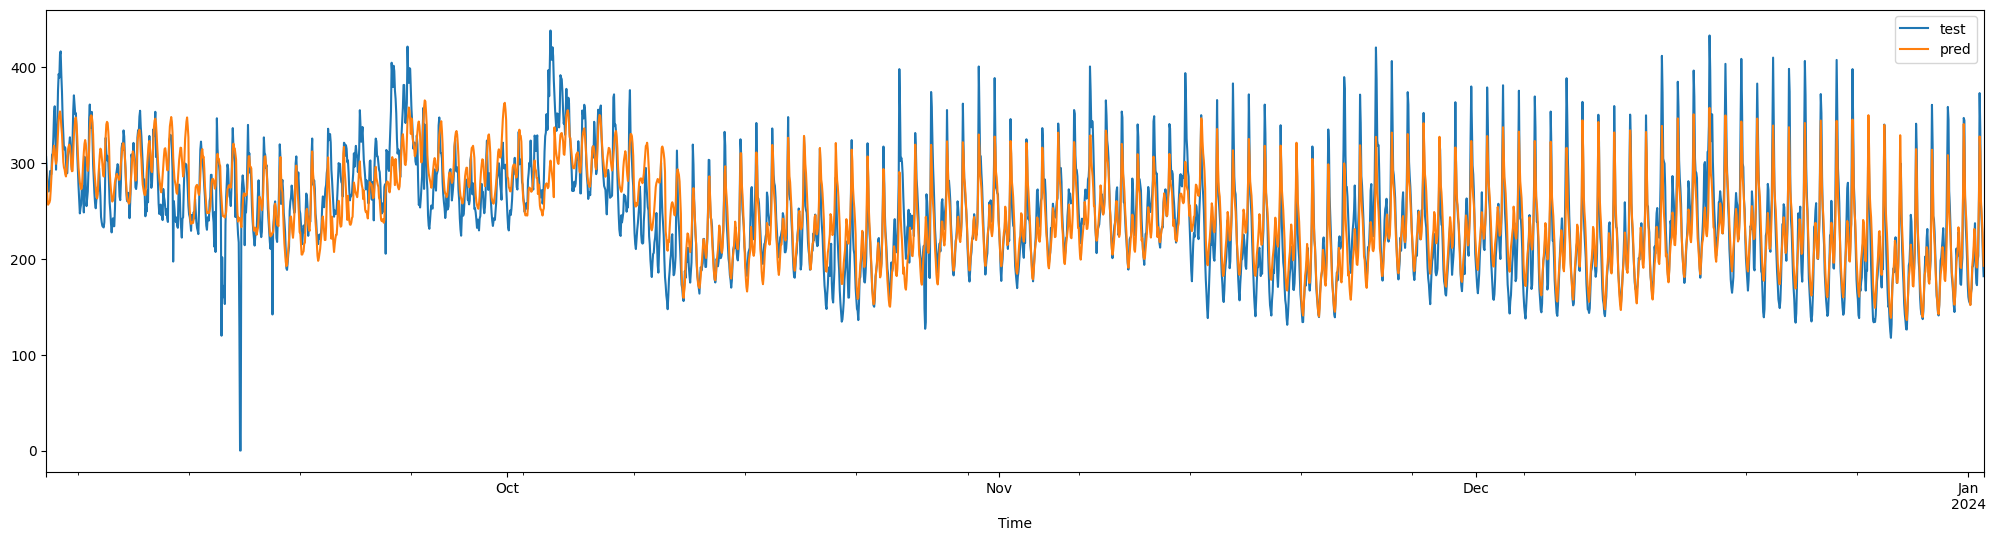

time: 768 ms (started: 2025-05-20 16:21:32 +00:00)


In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(25, 6))
#data_train['Demand(MWh)'].plot(ax=ax, label='train')
data_test[target].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
y_true = data_test[target]
y_pred = predictions
y_pred = y_pred.values.reshape(-1)

# Tính MSE và MAE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

# Tính MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 #lỗi do y_true có gtri = 0

# Tính Relative MAE (rel_mae)
mean_actual = np.mean(y_true)
rel_mae = 100 * (mae / mean_actual)
rel_rmse = 100 * (rmse / mean_actual)


# Hiển thị các kết quả
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'Relative MAE: {rel_mae}%')
print(f'Relative RMSE: {rel_rmse}%')

MSE: 885.9907704618282
RMSE: 29.765597095671176
MAE: 22.228270800580066
MAPE: inf%
Relative MAE: 9.047894578838072%
Relative RMSE: 12.115921522369316%
time: 6.83 ms (started: 2025-05-20 16:21:40 +00:00)


In [ ]:
!pip install joblib
import joblib

import joblib

# Ví dụ đường dẫn lưu: MyDrive/Models/forecaster_model.pkl
save_path = '/content/drive/MyDrive/19_5_Results/load_forecast_KNN_model.pkl'

# Lưu model
joblib.dump(forecaster, save_path)

print(f"Mô hình đã được lưu vào: {save_path}")

Mô hình đã được lưu vào: /content/drive/MyDrive/19_5_Results/load_forecast_KNN_model.pkl
time: 3.16 s (started: 2025-05-20 16:21:45 +00:00)


In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

save_data = {'MSE': mse, 'MAE' : mae,'RMSE' : rmse, 'Relative MAE' : rel_mae, 'Relative RMSE' : rel_rmse, 'train time' : train_time, 'test time' :test_time}

with open('/content/drive/MyDrive/19_5_Results/Autoreg_KNN_lags_only.pkl', 'wb') as f:
  pickle.dump(save_data, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.39 s (started: 2025-05-20 16:21:49 +00:00)


# Autoreg_Lags_and_exog

In [ ]:
import time
from sklearn.preprocessing import MinMaxScaler
forecaster= ForecasterAutoreg(
                    regressor = KNeighborsRegressor(),
                    lags      = 24, # This value will be replaced in the grid search
                                        #  transformer_exog = transformer_exog,

             )

# Lags used as predictors
lags_grid = [24*14,24*7]

search_spaces  = {
        'n_neighbors'          : Integer( 5, 50),
         'weights': Categorical([ 'uniform', 'distance']),
        'leaf_size'  : Integer( 30, 50),
    }

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'weights':trial.suggest_categorical('weights', ['uniform', 'distance']),
        'n_neighbors': trial.suggest_int('n_neighbors', 10, 100,step=10),
        'leaf_size': trial.suggest_int('leaf_size',30,50,step=5),
        'lags'   : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

start_time = time.time()
results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = merged_df.loc[:end_validation, target],
                                   exog               = merged_df.loc[:end_validation, fe],
                                   steps              = 24,
                                   metric             = 'mean_absolute_error',
                                   search_space       = search_space,
                                   initial_train_size = len(merged_df[:end_train]),
                                   refit              = 7,
                                   n_trials           = 60, # Increase for more exhaustive search
                                   random_state       = 123,
                                   return_best        = True,
                                   verbose            = False,
                                   show_progress      = True
                               )
end_time = time.time()
turning_time = end_time - start_time
print(turning_time)

  0%|          | 0/60 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
  Parameters: {'weights': 'uniform', 'n_neighbors': 40, 'leaf_size': 35}
  Backtesting metric: 25.798239679898284

430.04646277427673
time: 7min 10s (started: 2025-05-21 15:14:40 +00:00)


In [25]:
best_params = results_search.iloc[0].params
print(best_params)

best_lags = results_search.iloc[0].lags
print(best_lags)

{'weights': 'uniform', 'n_neighbors': 40, 'leaf_size': 35}
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
time: 1.78 ms (started: 2025-05-21 15:22:38 +00:00)


In [26]:
import time

# Siêu tham số tốt nhất sau quá trình tuning
# Tạo lại forecaster với các siêu tham số tốt nhất
forecaster= ForecasterAutoreg(
                    regressor = KNeighborsRegressor(**best_params),
                    lags      = best_lags, # This value will be replaced in the grid search
                                        #  transformer_exog = transformer_exog,

             )
start_time = time.time()
# Huấn luyện lại forecaster với dữ liệu huấn luyện
forecaster.fit(y=merged_df.loc[:end_validation, target], exog = merged_df.loc[:end_validation, fe])
# Backtesting model
# ==============================================================================
end_time = time.time()
train_time = end_time - start_time
print(train_time)

1.950474739074707
time: 1.95 s (started: 2025-05-21 15:25:05 +00:00)


In [ ]:
start_time = time.time()
#
# Backtesting model
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=merged_df[target],
    exog = merged_df[fe],
    steps=24,
    metric='mean_absolute_error',
    fixed_train_size   = True,
    initial_train_size=len(merged_df[:end_validation]),
    refit=7,
    n_jobs=2,
    verbose=False,
    show_progress=True
)
end_time = time.time()
# Extract the numeric value from the DataFrame
test_time = end_time - start_time
print(test_time)
# Extract the numeric value from the DataFrame
metric


/usr/local/lib/python3.11/dist-packages/skforecast/model_selection/model_selection.py:407: IgnoredArgumentWarning:

If `refit` is an integer other than 1 (intermittent refit). `n_jobs` is set to 1 to avoid unexpected results during parallelization. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)



  0%|          | 0/122 [00:00<?, ?it/s]

15.22471809387207


,mean_absolute_error
0,21.725892


time: 15.2 s (started: 2025-05-21 15:25:17 +00:00)


<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



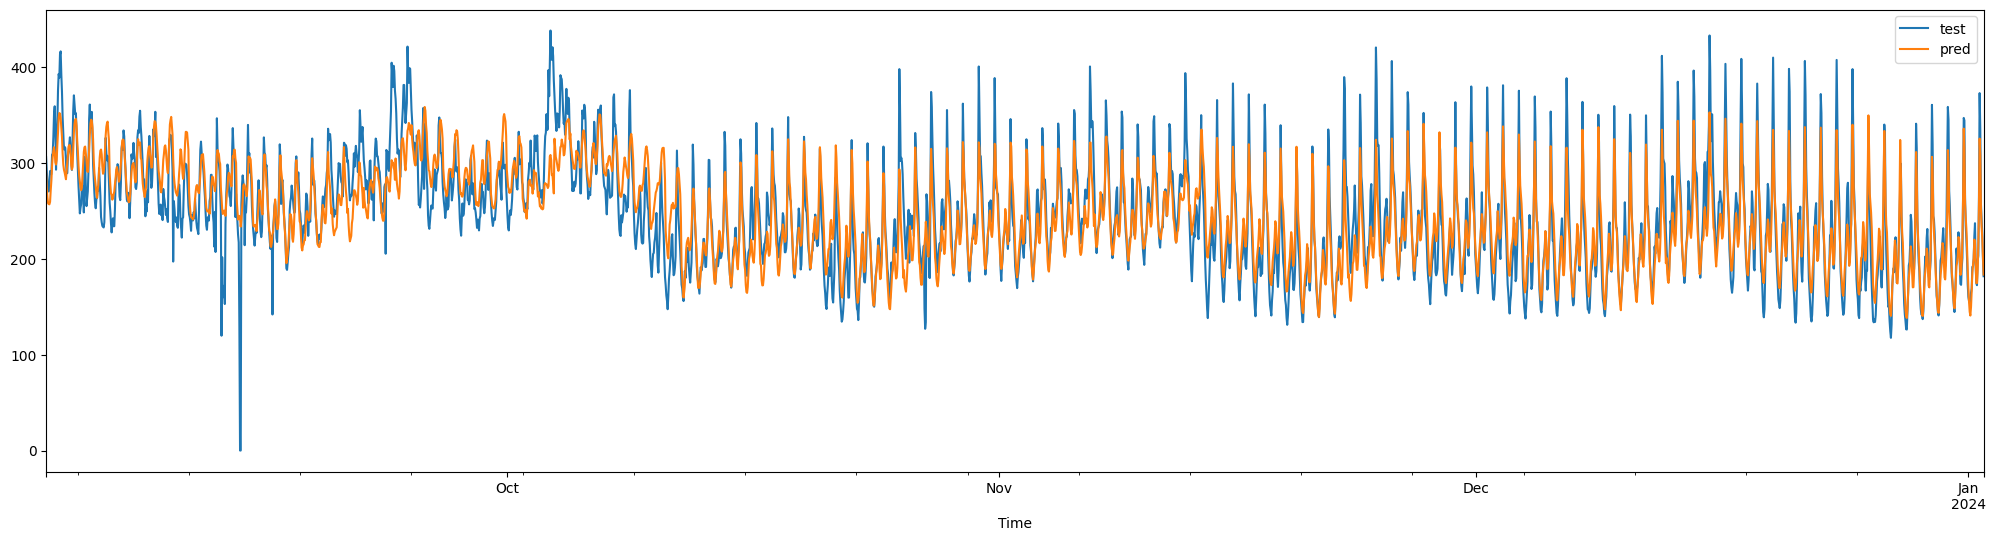

time: 641 ms (started: 2025-05-21 15:26:05 +00:00)


In [28]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(25, 6))
#data_train['Demand(MWh)'].plot(ax=ax, label='train')
data_test[target].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [29]:
# Test error
# ==============================================================================
y_true = data_test[target]
y_pred = predictions
y_pred = y_pred.values.reshape(-1)

# Tính MSE và MAE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

# Tính MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 #lỗi do y_true có gtri = 0

# Tính Relative MAE (rel_mae)
mean_actual = np.mean(y_true)
rel_mae = 100 * (mae / mean_actual)
rel_rmse = 100 * (rmse / mean_actual)


# Hiển thị các kết quả
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'Relative MAE: {rel_mae}%')
print(f'Relative RMSE: {rel_rmse}%')

MSE: 859.036579936638
RMSE: 29.3093258185281
MAE: 21.725891858554565
MAPE: inf%
Relative MAE: 8.843404011539587%
Relative RMSE: 11.930198824819914%
time: 7.03 ms (started: 2025-05-21 15:26:07 +00:00)


In [30]:
!pip install joblib
import joblib

import joblib

# Ví dụ đường dẫn lưu: MyDrive/Models/forecaster_model.pkl
save_path = '/content/drive/MyDrive/19_5_Results/load_forecast_KNN_lags_and_exog_model.pkl'

# Lưu model
joblib.dump(forecaster, save_path)

print(f"Mô hình đã được lưu vào: {save_path}")

Mô hình đã được lưu vào: /content/drive/MyDrive/19_5_Results/load_forecast_KNN_lags_and_exog_model.pkl
time: 4.07 s (started: 2025-05-21 15:30:21 +00:00)


In [31]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

save_data = {'MSE': mse, 'MAE' : mae,'RMSE' : rmse, 'Relative MAE' : rel_mae, 'Relative RMSE' : rel_rmse, 'train time' : train_time, 'test time' :test_time}

with open('/content/drive/MyDrive/19_5_Results/Autoreg_KNN_lags_and_exog.pkl', 'wb') as f:
  pickle.dump(save_data, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.68 s (started: 2025-05-21 15:30:35 +00:00)
